在conda的pytorch环境中运行  python -m deepxde.backend.set_default_backend pytorch  
将deepxde的默认后端更改为pytorch  

In [ ]:
!python torch_dde_temp.py

## Model

In [ ]:
from argparse import ArgumentParser

from tqdm import tqdm

import deepxde as dde
from deepxde.backend import torch
import numpy as np
import scipy.io

import math
import pandas as pd

from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl

import random
import argparse

print('GPU is available:', torch.cuda.is_available()) # 查看是否有可用GPU
print('GPU count :', torch.cuda.device_count()) # 查看GPU数量
print('GPU :', torch.cuda.get_device_name(0)) # 查看指定GPU名称
print('GPU capability :', torch.cuda.get_device_capability(0)) # 查看指定GPU容量


In [1]:

def float_init():
    dde.config.set_default_float("float64")


def set_random_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    dde.config.set_random_seed(args.seed)


def parser_init():
    parser = argparse.ArgumentParser(description='Laser Heating modeling')

    # 保存文件名及路径
    parser.add_argument('--training_name', type=str, default="Cuboid_temp")
    parser.add_argument('--save_model', action='store_false', default=True, help='whether to save the model')
    parser.add_argument('--save_path', type=str, default="/root/autodl-tmp/try") # 服务器路径
    # parser.add_argument('--save_path', type=str, default="E:/Desktop/PINN/work/try/dde_temp_torch")   # 本地路径

    # 时间、温度、几何尺寸 缩放系数 
    parser.add_argument('--k_t', type=int, default=2, help='heating time coefficient')
    parser.add_argument('--k_T', type=int, default=1000, help='temperature coefficient')
    parser.add_argument('--k_g', type=int, default=20, help='coordinate coefficient')

    # 随机种子
    parser.add_argument('--seed', type=int, default=2023, help='random seed')

    # 材料参数
    parser.add_argument('--Tam', type=float, default=20.0, help='temperature for environment,unit:℃')
    parser.add_argument('--is_CelsiusDegree', action='store_true', default=False,
                        help='whether to use Celsius Degree temperature or not')
    parser.add_argument('--h_c', type=float, default=0.02, help='film conduction constant,unit:mW/(mm^2*K)')
    parser.add_argument('--epsilon', type=float, default=0.85, help='radiation constant')
    parser.add_argument('--sigma', type=float, default=5.67e-11, help='Boltzmann constant,unit:mW/(mm^2*K^4)')
    parser.add_argument('--rho', type=float, default=7.78e-09, help='density,unit:t/mm^3')

    # 激光热源参数
    parser.add_argument('--X_t0', type=float, default=12.0, help='coordinate(x) of laser at t=0,unit:mm')
    parser.add_argument('--Y_t0', type=float, default=10.0, help='coordinate(y) of laser at t=0,unit:mm')
    parser.add_argument('--Z_t0', type=float, default=5.0, help='coordinate(z) of laser at t=0,unit:mm')
    parser.add_argument('--alaspow', type=float, default=1500000.0, help='laser power,unit:mW')
    parser.add_argument('--R_a', type=float, default=3.0, help='R(a) of laser spot,unit:mm')
    parser.add_argument('--R_b', type=float, default=3.0, help='R(b) of laser spot,unit:mm')
    parser.add_argument('--R_c', type=float, default=1.0, help='R(c) of laser spot,unit:mm')
    parser.add_argument('--scanvel', type=float, default=8.0, help='speed of laser spot,unit:mm/s')

    # 几何模型边界Coboid
    parser.add_argument('--X_min', type=float, default=0.0, help='minimum coordinate(x)')
    parser.add_argument('--X_max', type=float, default=40.0, help='maximum coordinate(x)')
    parser.add_argument('--Y_min', type=float, default=0.0, help='minimum coordinate(y)')
    parser.add_argument('--Y_max', type=float, default=20.0, help='maximum coordinate(y)')
    parser.add_argument('--Z_min', type=float, default=0.0, help='minimum coordinate(z)')
    parser.add_argument('--Z_max', type=float, default=5.0, help='maximum coordinate(z)')

    # 神经网络参数
    parser.add_argument('--num_domain', type=int, default=40000)
    parser.add_argument('--num_boundary', type=int, default=10000)
    parser.add_argument('--num_initial', type=int, default=20000)
    parser.add_argument('--lr', type=float, default=1e-3, help='learning rate of Adam')
    parser.add_argument('--iterations', type=int, default=25000, help='training epochs of Adam')
    parser.add_argument('--loss_weights', type=int, default=[1, 1, 1, 1, 1, 1, 1, 10])
    parser.add_argument('--display_freq', type=int, default=500)
 
    args = parser.parse_known_args()[0]
    return args


"""PDE functions"""
def define_model(args):

    # 参数输入及初步处理
    print('--- input_parameter')
    k_g, k_t, k_T = args.k_g, args.k_t, args.k_T
        
    # 输入 input = [x, y, z, t]
    # 输出 output = [c]

    # 缩放前:  [X, Y, Z, time] = [k_g * x, k_g * y, k_g * z, k_t * t]
    #          [temp] = [k_T * c]

    x_min, x_max = args.X_min/k_g, args.X_max/k_g
    y_min, y_max = args.Y_min/k_g, args.Y_max/k_g
    z_min, z_max = args.Z_min/k_g, args.Z_max/k_g

    scanvel = args.scanvel
    alaspow = args.alaspow
    
    R_a, R_b, R_c = args.R_a, args.R_b, args.R_c

    Tam = args.Tam + 273.15 if not args.is_CelsiusDegree else args.Tam

    rho = args.rho
    h_c, epsilon, sigma = args.h_c, args.epsilon, args.sigma


    # 导热系数
    def define_kp(output):
        temp = k_T * output
        one = torch.ones_like(temp)
        cond = torch.ge(temp, 1773)
        a1 = torch.where(cond, 1.04e-4 * one, 2e-5 * one)
        a2 = torch.where(cond, -0.3426 * one, -0.0444 * one)
        a3 = torch.where(cond, 314.2 * one, 49.94 * one)
        kp = a1 * temp ** 2 + a2 * temp + a3    # 导热系数（简化为二次项）
        kp_T = 2 * a1 * temp + a2   # 导热系数对温度的导数
        return kp, kp_T

    # 比热
    def define_cp(output):
        temp = k_T * output
        cp_1 = -53.704
        cp_2 = 326974
        cp_3 = 4e8
        cp = cp_1 * temp ** 2 + cp_2 * temp + cp_3  # 比热（简化为二次项）
        cp_T = 2 * cp_1 * temp + cp_2
        return cp, cp_T

    # 椭球形激光热源分布
    def Q_calc(input):
        Ra = torch.tensor(R_a, dtype=torch.float64)
        Rb = torch.tensor(R_b, dtype=torch.float64)
        Rc = torch.tensor(R_c, dtype=torch.float64)

        X_point, Y_point, Z_point = k_g * input[:, 0:1], k_g * input[:, 1:2], k_g * input[:, 2:3]
        time = k_t * input[:, 3:4]
        r2 = torch.square(X_point - args.X_t0 - scanvel * time) / torch.square(Ra) + torch.square(Y_point - args.Y_t0) / torch.square(Rb) + torch.square(Z_point - args.Z_t0) / torch.square(Rc)

        k1 = torch.tensor(3.0, dtype=torch.float64)
        k2 = torch.tensor(math.pi, dtype=torch.float64)
        q = 6 * torch.sqrt(k1) * alaspow / (Ra * Rb * Rc * k2 * torch.sqrt(k2)) * torch.exp(-3 * r2)
        return q

    # 微分导热方程
    def conduction(input, output):
        dc_dx = dde.grad.jacobian(output, input, i=0, j=0)
        dc_dy = dde.grad.jacobian(output, input, i=0, j=1)
        dc_dz = dde.grad.jacobian(output, input, i=0, j=2)
        dc_dt = dde.grad.jacobian(output, input, i=0, j=3)

        d2c_dxdx = dde.grad.hessian(output, input, i=0, j=0)
        d2c_dydy = dde.grad.hessian(output, input, i=1, j=1)
        d2c_dzdz = dde.grad.hessian(output, input, i=2, j=2)

        q = Q_calc(input)

        cp, cp_T = define_cp(output)

        kp, kp_T = define_kp(output)

        # 熔覆时带有激光热源q的PDE方程
        pde = dc_dt - k_t * ((d2c_dxdx + d2c_dydy + d2c_dzdz) * kp / (k_g ** 2) + 
                             kp_T * k_T * (dc_dx ** 2 + dc_dy ** 2 + dc_dz ** 2) / (k_g ** 2) + q / k_T) / (rho * cp)

        return pde

    # 对流、辐射换热
    def convection_radiation(input, output):
        temp = k_T * output
        k_p, _ = define_kp(output)
        return - k_g * (h_c * (temp - Tam) + epsilon * sigma * (temp ** 4 - Tam ** 4)) / (k_p * k_T)
    
    # 初始温度
    def initial_temp(input):
        return Tam / k_T

    # 定义各边界位置
    def boundary_left(input, on_boundary):
        return on_boundary and np.isclose(input[0], x_min)

    def boundary_right(input, on_boundary):
        return on_boundary and np.isclose(input[0], x_max)

    def boundary_foward(input, on_boundary):
        return on_boundary and np.isclose(input[1], y_min)

    def boundary_backward(input, on_boundary):
        return on_boundary and np.isclose(input[1], y_max)

    def boundary_down(input, on_boundary):
        return on_boundary and np.isclose(input[2], z_min)

    def boundary_upper(input, on_boundary):
        return on_boundary and np.isclose(input[2], z_max)
    

    print('--- space_domain')  # 空间域
    spatial_domain = dde.geometry.Cuboid([x_min, y_min, z_min], [x_max, y_max, z_max])

    print('--- time_domain')  # 时间域
    temporal_domain = dde.geometry.TimeDomain(0, 1)

    print('--- Geometry X Time')  # 域
    geom = dde.geometry.GeometryXTime(spatial_domain, temporal_domain)

    print('--- bc') # 边界条件
    bc_l = dde.icbc.RobinBC(geom, convection_radiation, boundary_left)
    bc_r = dde.icbc.RobinBC(geom, convection_radiation, boundary_right)
    bc_f = dde.icbc.RobinBC(geom, convection_radiation, boundary_foward)
    bc_b = dde.icbc.RobinBC(geom, convection_radiation, boundary_backward)
    bc_d = dde.icbc.RobinBC(geom, convection_radiation, boundary_down)
    bc_u = dde.icbc.RobinBC(geom, convection_radiation, boundary_upper)

    print('--- ic') # 初始条件
    ic = dde.icbc.IC(geom, initial_temp, lambda _, on_initial: on_initial)

    print('--- data = dde.data.TimePDE')
    data = dde.data.TimePDE(geom, conduction, [bc_l, bc_r, bc_f, bc_b, bc_d, bc_u, ic], 
                            num_domain=args.num_domain, num_boundary=args.num_boundary, num_initial=args.num_initial)
    
    print('--- net = dde.nn.FNN')
    # n = 10
    # activation = f"LAAF-{n} tanh"   # 激活函数
    activation = "tanh"   # 激活函数
    net = dde.nn.pytorch.fnn.FNN([4] + [20] * 5 + [1], activation, "Glorot uniform")   # 网络结构
    
    print('--- model = dde.Model(data, net)')
    model = dde.Model(data, net)

    return model


print('- args_init') 
args = parser_init()

print('- set_random_seed')
random.seed(args.seed) 
np.random.seed(args.seed) 
dde.config.set_random_seed(args.seed)
print('- float_init') 
dde.config.set_default_float("float64")

print('- define_model')
model = define_model(args)

ModuleNotFoundError: No module named 'deepxde'

## Restore

In [20]:
print('- model_compile_L-BFGS')
model.compile("L-BFGS")

print('- model_crestore')
model.restore(args.save_path + "/" + args.training_name + '-' + "25000.pt")

- model_compile_L-BFGS
Compiling model...
'compile' took 0.000200 s

- model_crestore


## Predict

In [27]:
# code for results visualization at a time
def Visualization(location, temperature, time):
    x, y, z = location[:,0:1], location[:,1:2], location[:,2:3]

    fig = plt.figure(figsize=(10,4),dpi=200)
    ax = fig.add_axes(Axes3D(fig))  

    norm = mpl.colors.Normalize(vmin=min(temperature), vmax=max(temperature))
    cm = plt.cm.get_cmap('plasma')

    ax.set_box_aspect((40,20,5))
    ax.set_xticks([0,10,20,30,40])
    ax.set_yticks([0,5,10,15,20])
    ax.set_zticks([0,5])

    im = ax.scatter3D(x,y,z,norm=norm, c=temperature, cmap=cm)

    position = fig.add_axes([0.15, 0.12, 0.015, 0.78])#位置[左,下,宽,高]
    cb = fig.colorbar(im, cax=position)
    colorbarfontdict = {"size":20,"color":"k",'family':'Times New Roman'}
    cb.ax.set_title('unit:K',fontdict=colorbarfontdict,pad=5)
    cb.ax.tick_params(labelsize=15,direction='in')

    title_fontdict = {"size":25,"color":"k",'family':'Times New Roman'}
    ax.set_title(f"PINN temperature at {time:.2f}s", fontdict=title_fontdict)

    text_fontdict = {"size":20,"color":"k",'family':'Times New Roman'}
    ax.text2D(-0.03, 0.05, f"Max temperature: {max(temperature)[0]:.0f}K", fontdict=text_fontdict)

    plt.show()

In [28]:
x_min, y_min, z_min = 0, 0, 0

dg = 0.4
dt = 0.05
x_start, x_stop = 0, 40
y_start, y_stop = 0, 20
z_start, z_stop = 0, 5
t_start, t_stop = 1, 1

k_g = 20
k_t = 2
k_T = 1000

x = np.arange(x_start, x_stop + dg , dg, dtype = float) if not x_start == x_stop  else np.array([x_start], dtype = float)
y = np.arange(y_start, y_stop + dg , dg, dtype = float) if not y_start == y_stop  else np.array([y_start], dtype = float)
z = np.arange(z_start, z_stop + dg , dg, dtype = float) if not z_start == z_stop  else np.array([z_start], dtype = float)
t = np.arange(t_start, t_stop + dt , dt, dtype = float) if not t_start == t_stop  else np.array([t_start], dtype = float)

x_mesh, y_mesh, z_mesh, t_mesh = np.meshgrid(x, y, z, t)
X_input, Y_input, Z_input, time_input = x_mesh.reshape(-1,1), y_mesh.reshape(-1,1), z_mesh.reshape(-1,1), t_mesh.reshape(-1,1)
location = np.hstack((X_input, Y_input, Z_input, time_input))


x_input, y_input, z_input = (X_input - x_min) / k_g, (Y_input - y_min) / k_g, (Z_input - z_min) / k_g
t_input  = time_input / k_t

input = np.hstack((x_input, y_input, z_input, t_input))
print('shape of input is (%d, %d) '%(input.shape[0], input.shape[1]))


output = model.predict(input)
print('shape of output is (%d, %d) '%(output.shape[0], output.shape[1])) 

temp = output * k_T


print('Temperature min is %.2f K, max is %.2f K' %(min(temp),max(temp)))

shape of input is (72114, 4) 
shape of output is (72114, 1) 
Temperature min is 294.03 K, max is 2735.17 K


/tmp/ipykernel_207/3951248453.py:6: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = fig.add_axes(Axes3D(fig))


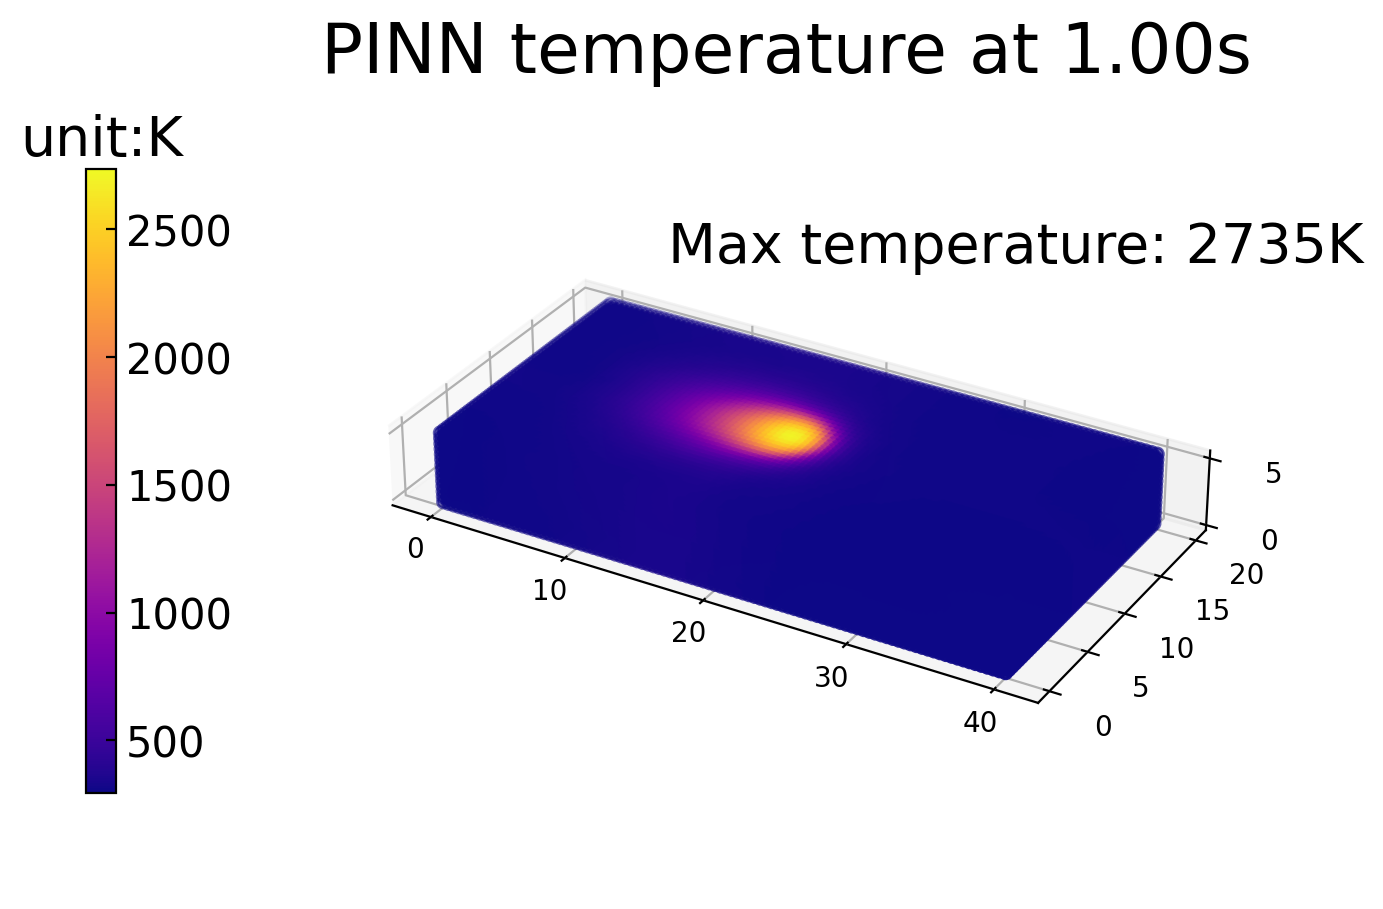

In [29]:
Visualization(location, temp, t_start)